In [1]:
%load_ext autoreload
%autoreload 2

In [223]:
import celestializer as cl
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import cv2

In [224]:
img_sky = cl.RawImage(cl.Paths.observations / "2024-11-05/IMG_3320.CR2").load()
img = img_sky.raw()
img_sky.metadata.model_dump()

{'width': 5202,
 'height': 3465,
 'focal_length': 18.0,
 'aperture': 3.5,
 'shutter': 10.0,
 'iso': 6400,
 'timestamp': datetime.datetime(2024, 11, 5, 0, 37, 58),
 'camera': 'Canon EOS 1200D',
 'bit_depth': 14}

In [225]:
img_in = img.green_interpolated()
img_in = cl.correct_vignette(img_in)
img_in = img_in.channel("green")

mask_hot, mask_dead = cl.find_defects(img_in)
print(f"Found {mask_hot.sum()} hot pixels and {mask_dead.sum()} dead pixels")
mask = mask_hot | mask_dead
img_in = cl.replace_defects(img_in, mask)
img_in = img_in.green_interpolated()
img_in -= img_in.min()
img_in /= img_in.max()

Found 42 hot pixels and 107 dead pixels


In [226]:
mask = cl.classify_star_pixels(img_in.to_bitdepth(8))
stars = cl.stars_from_mask(mask)
print(f"Found {len(stars)} stars")

100%|██████████| 914/914 [00:06<00:00, 134.97it/s]


Found 914 stars


Min magnitude: 0.5776379704475403
Max magnitude: 101.40133666992188


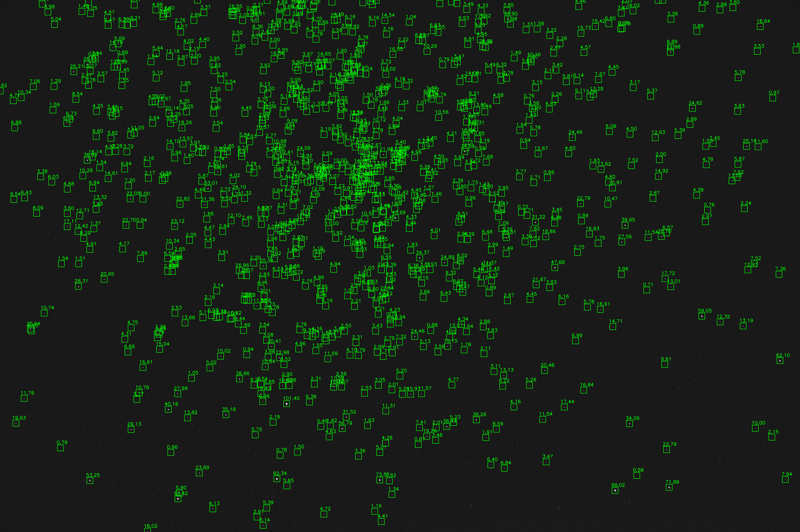

In [134]:
def predict_magnitude(img: cl.ImageNBit, star: cl.StarPixels) -> cl.StarMag:
    # Extract star pixels
    star_pixels = img[
        star.bbox[1] : star.bbox[1] + star.bbox[3],
        star.bbox[0] : star.bbox[0] + star.bbox[2],
    ]
    star_pixels = star_pixels[star.mask]
    magnitude = star_pixels.sum()
    return cl.StarMag(x=star.x, y=star.y, magnitude=magnitude)

img_pred = img_in.to_bitdepth(1)
predictions = [predict_magnitude(img_pred, star) for star in stars]
magnitudes = [p.magnitude for p in predictions]
print(f"Min magnitude: {min(magnitudes)}")
print(f"Max magnitude: {max(magnitudes)}")
# Show result
img_out = cl.show_stars(img_in, predictions)
img_out.preview().show()
img_out.save(cl.Paths.saved / "stars_pixel_sum.png")

In [6]:
stars_top = sorted(predictions, key=lambda p: p.magnitude, reverse=True)[:60]
match = cl.find_coordinates(stars_top, cl.CameraInfo())
print(f"Matched {len(match.stars)} stars")

Finding coordinates


ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (2 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (5 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-w

Matched 107 stars


In [135]:
from sklearn.neighbors import NearestNeighbors


def match_catalog(
    query: list[cl.StarCenter],
    catalog: list[cl.StarCenter],
    max_distance: float = float("inf"),
) -> list[tuple[int, int]]:
    query = np.array([[star.x, star.y] for star in query])
    catalog = np.array([[star.x, star.y] for star in catalog])
    nn = NearestNeighbors(n_neighbors=1).fit(catalog)
    distances, indices = nn.kneighbors(query)
    distances = distances.flatten()
    indices = indices.flatten()
    # Filter out matches that are too far
    matches = [
        (i, j) for i, j, d in zip(range(len(indices)), indices, distances) if d < max_distance
    ]
    return matches


# Convert catalog stars to pixel coordinates
wcs = match.astropy_wcs()
stars_catalog: list[cl.StarMag] = []
for star in match.stars:
    x, y = wcs.all_world2pix([[star.ra_deg, star.dec_deg]], 1)[0]
    stars_catalog.append(cl.StarMag(x=int(x), y=int(y), magnitude=star.metadata["MAG"]))
    
matches = match_catalog(predictions, stars_catalog, max_distance=4)
print(f"Matched {len(matches)} stars")
for i in range(len(matches)):
    m_pred, m_cat = matches[i]
    print(f"Star {i}: {predictions[m_pred].magnitude} -> {stars_catalog[m_cat].magnitude}")

Matched 93 stars
Star 0: 15.4171781539917 -> 4.849999904632568
Star 1: 10.778928756713867 -> 5.254000186920166
Star 2: 15.734618186950684 -> 4.915999889373779
Star 3: 22.979965209960938 -> 4.340000152587891
Star 4: 26.847171783447266 -> 4.125999927520752
Star 5: 27.989307403564453 -> 3.9639999866485596
Star 6: 26.209075927734375 -> 4.265999794006348
Star 7: 15.519328117370605 -> 4.888000011444092
Star 8: 24.616775512695312 -> 4.311999797821045
Star 9: 13.847904205322266 -> 5.0879998207092285
Star 10: 18.636518478393555 -> 4.658999919891357
Star 11: 24.486635208129883 -> 4.390999794006348
Star 12: 25.1801815032959 -> 4.2789998054504395
Star 13: 34.581546783447266 -> 3.1730000972747803
Star 14: 24.088197708129883 -> 4.206999778747559
Star 15: 12.667495727539062 -> 5.197000026702881
Star 16: 21.98470115661621 -> 4.446000099182129
Star 17: 14.144983291625977 -> 5.109000205993652
Star 18: 36.625762939453125 -> 3.6110000610351562
Star 19: 13.620949745178223 -> 5.144000053405762
Star 20: 19.6

In [136]:

def func(x, a, b, c, d):
    return a * np.exp(-b * (x / 100 - c)) + d

pixel_sums = np.asarray([predictions[i].magnitude for i, j in matches])
true_mags = np.asarray([stars_catalog[j].magnitude for i, j in matches])
popt, pcov = curve_fit(func, pixel_sums, true_mags)
print(popt)

[0.90590176 1.45527705 1.24429017 0.51021885]


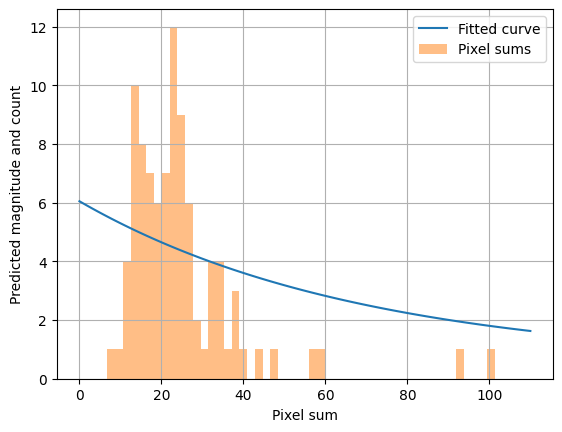

In [137]:
# Plot fitted curve
x = np.linspace(0, 110, 100)
y = func(x, *popt)
plt.figure()
plt.plot(x, y, label="Fitted curve")
plt.hist(pixel_sums, bins=50, alpha=0.5, label="Pixel sums")
# plt.yscale("log")
plt.grid()
plt.xlabel("Pixel sum")
plt.ylabel("Predicted magnitude and count")
plt.legend()
plt.savefig(cl.Paths.saved / "histogram_fitted.png", dpi=300, bbox_inches="tight")
plt.show()

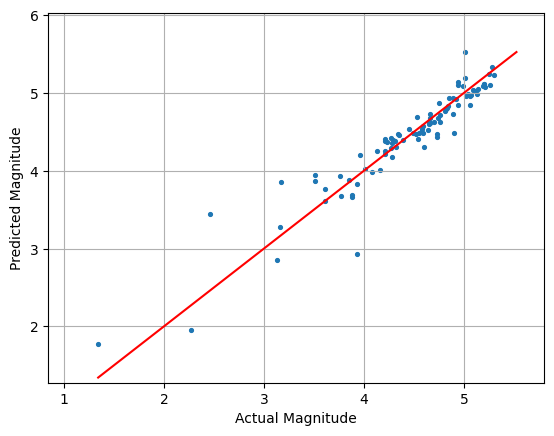

Mean error: 0.14610116326907738
Std error: 0.17215167314404262

Max error: 0.9945506673274425
Min error: 0.0002761518328906476


In [141]:
pred_mags = func(pixel_sums, *popt)
xlim = [true_mags.min(), true_mags.max()]
ylim = [pred_mags.min(), pred_mags.max()]
line = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]

# Plot comparison
plt.figure()
plt.scatter(true_mags, pred_mags, marker=".", s=30)
plt.plot(line, line, color="red")
plt.xlim([xlim[0] - 0.5, xlim[1] + 0.5])
plt.ylim([ylim[0] - 0.5, ylim[1] + 0.5])
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.grid()
plt.savefig(cl.Paths.saved / "fitted_training.png", dpi=300, bbox_inches="tight")
plt.show()

# Calculate error
error = np.abs(true_mags - pred_mags)
print(f"Mean error: {error.mean()}")
print(f"Std error: {error.std()}")
print()
print(f"Max error: {error.max()}")
print(f"Min error: {error.min()}")

In [96]:
# https://simbad.cds.unistra.fr/simbad/tap/help/adqlHelp.html
# def degree_per_pixel(wcs: WCS) -> float:
#     # Calculate difference in RA and DEC for 1 pixel
#     ra1, dec1 = wcs.all_pix2world(0, 0, 0)
#     ra2, dec2 = wcs.all_pix2world(1000, 0, 0)
#     return np.sqrt((ra2 - ra1) ** 2 + (dec2 - dec1) ** 2) / 1000


wcs = match.astropy_wcs()
# Calculate radius of image
diag = np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)
radius_img = diag / 2 * match.scale_arcsec_per_pixel / 3600 * u.deg * 1.01

print(f"Querying for radius {radius_img}")
print("Sending query to Simbad")
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields("main_id", "ra", "dec", "otype", "V")
result = simbad.query_region(
    SkyCoord(
        ra=match.center_ra_deg, dec=match.center_dec_deg, unit=(u.deg, u.deg)
    ),
    radius=radius_img,
    criteria='"otype"=\'Star..\' and "V" < 8',
)
print(f"Found {len(result)} stars")

Querying for radius 41.038210791346145 deg
Sending query to Simbad
Found 7011 stars


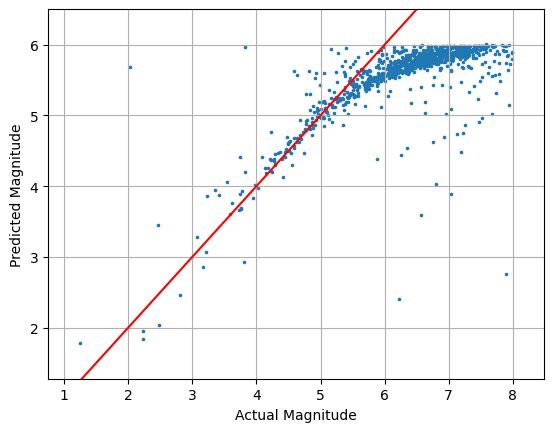

Mean error: 0.792750366011055
Std error: 0.6026856808678982

Max error: 5.14573008359511
Min error: 0.0002624740689043392


In [143]:
xys = np.array([[star.x, star.y] for star in stars]).T
ras, decs = wcs.all_pix2world(xys[0], xys[1], 0)
prompts = SkyCoord(ra=ras, dec=decs, unit=(u.deg, u.deg))
catalog = SkyCoord(ra=result["ra"], dec=result["dec"], unit=(u.deg, u.deg))
idx, d2d, d3d = prompts.match_to_catalog_sky(catalog)

ground_truth: list[cl.StarMag] = []
for i in range(len(idx)):
    star = stars[i]
    star_catalog = result[idx[i]]
    ground_truth.append(cl.StarMag(
        x=star.x, y=star.y, magnitude=star_catalog["V"]
    ))
img_out = cl.show_stars(img_in, ground_truth)

pred_mags = np.asarray([star.magnitude for star in predictions])
pred_mags = func(pred_mags, *popt)
true_mags = np.asarray([star.magnitude for star in ground_truth])
xlim = [true_mags.min(), true_mags.max()]
ylim = [pred_mags.min(), pred_mags.max()]
line = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]

# Plot comparison
plt.figure()
plt.scatter(true_mags, pred_mags, marker=".", s=10)
plt.plot(line, line, color="red")
plt.xlim([xlim[0] - 0.5, xlim[1] + 0.5])
plt.ylim([ylim[0] - 0.5, ylim[1] + 0.5])
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.grid()
plt.savefig(cl.Paths.saved / "fitted_validation.png", dpi=300, bbox_inches="tight")
plt.show()

# Calculate error
error = np.abs(true_mags - pred_mags)
print(f"Mean error: {error.mean()}")
print(f"Std error: {error.std()}")
print()
print(f"Max error: {error.max()}")
print(f"Min error: {error.min()}")

In [218]:
# Fit power function to predicted magnitudes
def pred_func(m, n0, a, m0):
    return np.pow(10, n0 + a * (m - m0))

hist, bins = np.histogram(pred_mags, bins=100)
pred_bins = (bins[:-1] + bins[1:]) / 2
pred_popt, _ = curve_fit(pred_func, pred_bins, hist, bounds=([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))
print(pred_popt)

[1.01106329 1.03318811 5.08453673]


In [219]:
# Fit power function to actual magnitudes
def true_func(m, n0, a, m0):
    return np.pow(10, n0 + a * (m - m0))

hist, bins = np.histogram([star["V"] for star in result], bins=100)
true_bins = (bins[:-1] + bins[1:]) / 2
true_popt, _ = curve_fit(true_func, true_bins, hist, bounds=([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))
print(true_popt)

[0.16140842 0.49202167 2.61792466]


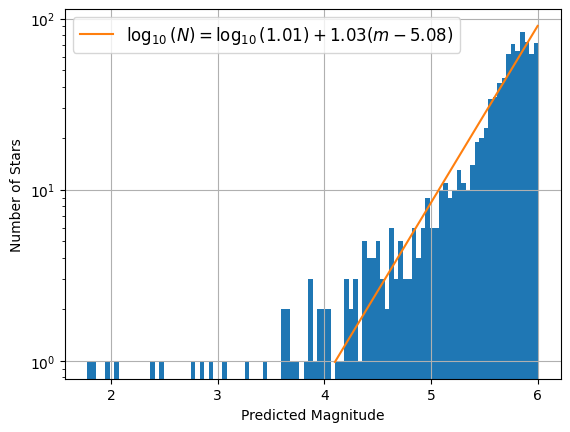

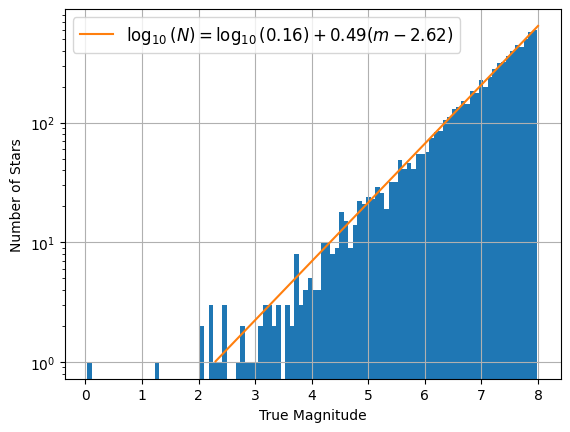

In [222]:
# Histogram predicted magnitudes
label_str = "$\\log_{10}(N) = \\log_{10}(%.2f) + %.2f (m - %.2f)$"

x1 = np.linspace(4.1, 6, 100)
plt.figure()
plt.hist(pred_mags, bins=100)
plt.plot(x1, pred_func(x1, *pred_popt), label=label_str % tuple(pred_popt))
plt.xlabel("Predicted Magnitude")
plt.ylabel("Number of Stars")
# plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize="large")
plt.grid()
plt.savefig(cl.Paths.saved / "source_count_predicated.png", dpi=300, bbox_inches="tight")

x2 = np.linspace(2.3, 8, 100)
plt.figure()
plt.hist([star["V"] for star in result], bins=100)
plt.plot(x2, true_func(x2, *true_popt), label=label_str % tuple(true_popt))
plt.xlabel("True Magnitude")
plt.ylabel("Number of Stars")
# plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize="large")
plt.grid()
plt.savefig(cl.Paths.saved / "source_count_true.png", dpi=300, bbox_inches="tight")
plt.show()

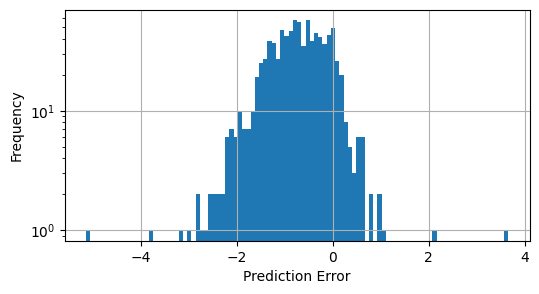

In [203]:
# Histogram prediction error
plt.figure(figsize=(6, 3))
plt.hist(pred_mags - true_mags, bins=100)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.yscale("log")
plt.grid()
plt.savefig(cl.Paths.saved / "prediction_error.png", dpi=300, bbox_inches="tight")
plt.show()

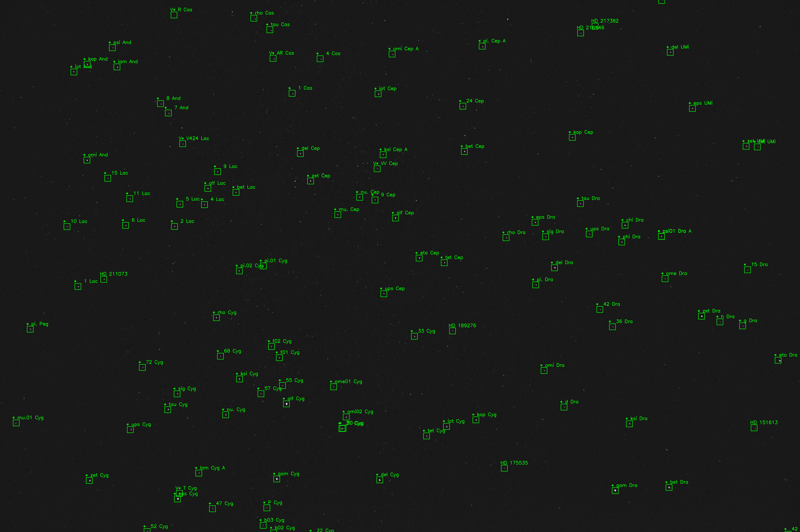

In [101]:

# Variant of core.py definition
def show_stars(
    img: cl.ImageNBit,
    stars: list[cl.StarCenter],
    radius: int = 40,
    labels: list[str] | None = None,
) -> cl.ImageNBit:
    img = img.to_bitdepth(8)
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    half_radius = radius // 2
    for idx, star in enumerate(stars):
        img = cv2.rectangle(
            img,
            (star.x - half_radius, star.y - half_radius),
            (star.x + half_radius, star.y + half_radius),
            (0, 255, 0),
            2,
        )
        if not labels:
            continue
        img = cv2.putText(
            img,
            labels[idx],
            (star.x - half_radius - 5, star.y - half_radius - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
        )
    return cl.ImageNBit(image=img, bit_depth=8)

labels = []
stars_labelled = []
wcs = match.astropy_wcs()
for star in result:
    if star["V"] > 5:
        continue
    try:
        x, y = wcs.all_world2pix([[star["ra"], star["dec"]]], 1)[0]
    except Exception as e:
        print(e)
        continue
    stars_labelled.append(cl.StarCenter(x=int(x), y=int(y)))
    labels.append(star["main_id"])
    
img_out = show_stars(img_in, stars_labelled, labels=labels)
img_out.preview().show()
img_out.save(cl.Paths.saved / "stars_brightest_labelled.png")


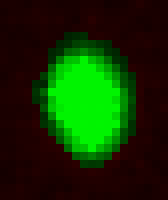

Pix sum: 101.40133666992188
Predicted mag: 1.7767631043830532
Actual mag: 1.343000054359436


In [124]:
def show_star_pixels(img: cl.ImageNBit, star: cl.StarPixels) -> cl.ImageNBit:
    star_pixels = img[
        star.bbox[1] : star.bbox[1] + star.bbox[3],
        star.bbox[0] : star.bbox[0] + star.bbox[2],
    ].copy()
    # Convert image to 3 channels
    star_color = np.zeros(
        (star_pixels.shape[0], star_pixels.shape[1], 3), dtype=img.dtype
    )
    for i in range(3):
        star_color[:, :, i] = star_pixels
    star_color[~star.mask, 1] = 0
    star_color[~star.mask, 2] = 0
    star_color[star.mask, 0] = 0
    star_color[star.mask, 2] = 0
    return cl.ImageNBit(star_color, img.bit_depth)

# Find brightest star
# Get its pixel sum
# Get its actual magnitude
catalog_mags = np.array([star.magnitude for star in stars_catalog])
b_catalog_idx = np.argmin(catalog_mags)
actual_mag = stars_catalog[b_catalog_idx].magnitude
# Find the corresponding star in "predictions"
b_stars_idx = -1
for i, star in enumerate(matches):
    if star[1] == b_catalog_idx:
        b_stars_idx = star[0]
        break

brightest = stars[b_stars_idx]
brightest = cl.StarPixels(
    x=brightest.x + 2,
    y=brightest.y + 2,
    bbox=[brightest.bbox[0] - 4, brightest.bbox[1] - 4, brightest.bbox[2] + 8, brightest.bbox[3] + 8],
    mask=np.pad(brightest.mask, 4, constant_values=False),
)
brightest_img = show_star_pixels(img_in, brightest)
brightest_img.upscale(8).show()
brightest_img.upscale(16).save(cl.Paths.saved / "brightest_star.png")
pixel_sum = predictions[b_stars_idx].magnitude
print(f"Pix sum: {pixel_sum}")
print(f"Predicted mag: {func(pixel_sum, *popt)}")
print(f"Actual mag: {actual_mag}")